 ##### In the terminology of machine learning, the dataset is called a training dataset or training set, and each row (containing the data corresponding to one sale) is called an example (or data point, instance, sample). The thing we are trying to predict (price) is called a label (or target). The variables (age and area) upon which the predictions are based are called features (or covariates).

In [4]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

##### In a linear regression there are several assumptions. The first being that the realtionship between the fatures $\bm{x}$ and target $\bm{y}$ is approximately linear,i.e., that the condiotnal mean $E[Y \mid X=x]$ can be expressed as a weighted sum of the features $\bm{x}$. This setup allows that the target value may still deviate from its expected value on account of observation noise. In general we impose the assumption that the noise is wel behaved i.e. has a Gaussian distribution.  

The assumption of linearity means that the expectde value of the target can be expressed as a weighted sum of the features (area and age):

<a id="eq1"></a>
$$
price = w_{area} * area + w_{age} * age + b
$$

where, $w_{area}$ and $w_{age}$ are the corresponding weights and $b$ is the bias. The weights express the influence of each feature on our prediction. 

#### <font color='red'>The above [equation 1](#eq1) is an affine transformation of the input features, which is characterized by a linear transformation of features via a weighted sum, combined with a translation via the added bias.</font>  

#### <font color='lightgreen'>So the goal is to choose the weights "w" and the bias "b" such that on average, we can make our models predictions fit the true prices observed in the data as closely as possible. </font>

In machine learning we usually work with datasets with higher dimensions so it is more convinient to apply compact linear algebra notation. Assuming our datapoints have $d$-dimensions, we can express our prediction $\bm{\hat{y}}$ as,

<a id="eq2"></a>
$$
\hat{y} = w_1x_1 + w_2x_2 + \dots +w_dx_d + b  
$$

The features can be clubbed into a single vector $\bm{x} \in R^d $ and all weights into a vector $\bm{w} \in R^d$ and thus we can express our model compactly via the dot product between $\bm{w}$ and $\bm{x}$:

<a id="eq3"></a>
$$
\bm{\hat{y}} = \bm{w}^T\bm{x} + b
$$

So when we consider a dataset with n examples and d features we can represent the $\text{design matrix}$ as $\mathbf{X} \in R^{n \times d}$. The predictions $\mathbf{\hat{y}} \in R^n$ can be expressed as a matrix-vector product:

$$

\hat{y}  = \mathbf{Xw} + b,
$$

Given features of a training dataset $\mathbf{X}$ and corresponding (known) labels $\mathbf{y}$, the goal of linear regression is to find the weight vector $\mathbf{w}$ and the bias term $b$ such that, given features of a new data example sampled from the same distribution as $\mathbf{X}$, the new example’s label will (in expectation) be predicted with the smallest error.

#### <font color='red'> Before we can go about searching for the best parameters (or model parameters) the weights "w" and the bias "b" and , we will need two more things: (i) a measure of the quality of some given model; and (ii) a procedure for updating the model to improve its quality. </font>



# Loss Function

Loss functions quantify the distance between the real and the predicted values of the target. Loss will be usually a non-negative number where smaller values are better. For regression problems the most common loss function is the sqaured error loss. For an example $i$, the sqaured error between the predicted and the true label is given by,

$$
l^i(\bm{w},b) = \dfrac{1}{2}(\hat{y}^i-y^i)^2
$$

where, 

$$
\hat{y}^i = w^Tx^i+b
$$

Note that large differences between estimates $\hat{y}^i$ and targets $y^i$ lead to even larger contributions to the loss, due to its quadratic form (this quadraticity can be a double-edge sword; while it encourages the model to avoid large errors it can also lead to excessive sensitivity to anomalous data).  

To measure the quality of a model on the entire dataset of n examples we simply average the losses on the training set:

$$
L(\bm{w},b) = \dfrac{1}{n}\sum_{i=1}^{n}l^i(\bm{w},b) = \dfrac{1}{n}\sum_{i=1}^{n}\dfrac{1}{2}(\bm{w}^Tx^i + b -y^i)^2
$$

While training the model, we seek the parameters ($\bm{w^*}$ and $\bm{b^*}$) that minimize the total loss across all training examples:

$$
\bm{w^*}, \bm{b^*} = \argmin_{w,b} L (\bm{w},b)
$$

# Analytic Solution

Linear regression provides the simplest optimization problem among all other models. Subsuming the bias term $b$ into the parameter space of $\bm{w}$ by appending a column of 1's in the design matrix $\bm{X}$ the prediction problem simplifies to minimization of $\mid\mid \bm{y} - \bm{X}\bm{w} \mid \mid ^2$. 

#### <font color='red'> So as long as the design matrix is a full rank matrix (none of the feature columns are dependent on each other), there will be only one critical point on the loss surface and it corresponds to the minimum of the loss over the entire domain. Takign the derivative of the loss with respect to "w" and setting it equal to zero yields: </font>  

$$
\delta_w\mid\mid \bm{y}-\bm{X}\bm{w} \mid\mid^2 = 2\bm{X}^T(\bm{X}\bm{w}-\bm{y}) = 0 \hspace{1mm} \text{and hence} \hspace{1mm} \bm{X}^T\bm{y} = \bm{X}^T\bm{X}\bm{w}
$$

Now solving for $\bm{w}$ gives us the optimal solution for the optimization problem. 

$$
\bm{w}^* = (\bm{X}^TX)^{-1}\bm{X}^T\bm{y}
$$

####  This solution will be unique when the matrix $X^TX$ is invertible,i.e.,when the columns of the design matrix are linearly independent.


# Minibatch Stochastic gradient descent 

The key technique for optimizing nearly every deep learning model, and which we will call upon throughout this book consists of iteratively reducing the error by updating the parameters in the direction that incrementally lowers the loss function. This algorithm is called $\textit{gradient descent (GD)}$.  

A naive way of implementing $\textit{gradient descent}$ is by taking the derivative of the loss function (the average of all the losses over every single example in the dataset). In practice the entire dataset is passed before a single update which can be slow even when the update steps are powerful. In the presence of redundancy in the training data, the benifit of full update is limited.

Another way of optimization is called the $\textit{stochastic gradient descent (SGD)}$ in which a single example is considered at a time and update steps are taken based on one observation at a time. Although it can be an effective strategy still it has certain computational and statistical limitations.  

1. Processors are a lot faster at multiplying and adding numbers than they are at moving data from main memory to processor cache. It can take a lot longer to process one sample at a time compared to a full batch. 

2. Some steps such as batch normalization only work well when we have access to more than one observation at a time. 

#### <font color = 'red' > The solution to both gradient descent and stochastic gradient descent is by taking a randomly selected minibatch of training samples. The choice of this minibatch depends on many factoirs, such as the amount of memory, the number of accelerators, the choice of layers, and the total dataset size. </font>

#### <font color = 'lightblue'> Despite all that a number between 32 and 256 preferably a multiple of a large power of 2, is a good start. </font> This gives the <font color = 'lightgreen'> minibatch stochastic gradient descent.</font>

The most basic form of <font color = 'lightgreen'> minibatch stochastic gradient descent</font> involves randomly choosing a minibatch $\mathcal{B}_t$ for every iteration $t$. Every batch consists of a fixed number ($\mathcal{B}$) of training examples. After this the derivative is computed of the average loss on the minibatch with respect to the model parameters. Finally, the gradient is multiplied with a predefined/ predetermined learning rate ($\eta$) and the resulting term is substracted from the current parameter values. The update of the model parameters can be expressed as,

$$
(\bm{w},b) \leftarrow (\bm{w},b) - \dfrac{\eta}{\lvert \mathcal{B} \rvert}\sum_{i \in \mathcal{B}_t} \delta_{(w,b)}l^i(\bm{w},b)
$$

$$
\bm{w} \leftarrow \bm{w} - \dfrac{\eta}{\lvert \mathcal{B} \rvert}\sum_{i \in \mathcal{B}_t} \delta_{w}l^i(\bm{w},b)         \hspace{6mm}  = \bm{w} - \dfrac{\eta}{\lvert \mathcal{B} \rvert}\sum_{i \in \mathcal{B}_t} \bm{x}^i(\bm{w}^T\bm{x}^i+b-\bm{y}^i) 
$$

$$
b \leftarrow b - \dfrac{\eta}{\lvert \mathcal{B} \rvert}\sum_{i \in \mathcal{B}_t} \delta_{b}l^i(\bm{w},b)         \hspace{6mm}  = b - \dfrac{\eta}{\lvert \mathcal{B} \rvert}\sum_{i \in \mathcal{B}_t}(\bm{w}^T\bm{x}^i+b-\bm{y}^i) 
$$

#### <font color = 'red'> The minibatch size and the learning rate are user defined and are not learning during the training process. They are called as the hyperparameters of the model.</font> They can be automatically tuned by a number of techniques such as Bayesian optimization. 


#### Hence once we obtain the model, $\hat{w}^T\bm{x}+\hat{b}$ we can now make predictions for a new example. Deep learning practitioners call this step as $\textit{inference}$.  


# Vectorization for speed

When training our models we typically want to process whole minibatches of examples simultaneously. So for doing this we require to efficiently vectorize the calculations and leverage linear algebra libraries rather than writing costly for-loops in Python.

In [2]:
n = 10000

a = torch.ones(n)
b = torch.ones(n)
c = torch.zeros(n)

t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]

f'{time.time() - t:.5f} sec'    



'0.05073 sec'

In [3]:
t = time.time()

d = a+b

f'{time.time() - t:.5f} sec'

'0.00100 sec'

### <font color ='red'>Vectorizing the code often yields order-of-magnitude speedups. Moreover, we push more of the mathematics to the library so we donot have to write as many calculations ourselves, reducing the potential for errors and increasing portability of the code.</font> 

# The Normal Distribution and the Squared Loss

The optimal parameters from the sqaured loss return the condtional expectation $E[Y \mid X]$ whenever the underlying pattern is truly linear and the loss assigns large penalties for outliers. 

<font color = 'lightgreen'> A more formal motivation for the squared loss objective can be made by making probabilistic assumptions about the distribution of noise.</font>  

The normal distribution with mean $\mu$ and variance $\sigma^2$ is given as,

$$
p(x) = \dfrac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\dfrac{1}{2\sigma^2}(x-\mu)^2\right)
$$

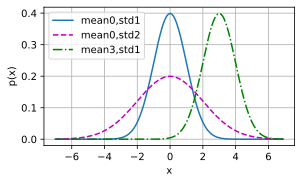

In [7]:
def normal(x, mu, sigma):
    p = 1/np.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5*(x-mu)**2/sigma**2)

x = np.arange(-7,7,0.1)

params = [(0,1),(0,2),(3,1)]
d2l.plot(x, [normal(x, mu, sigma) for mu,sigma in params], xlabel ='x',
         ylabel='p(x)', figsize=(4.5,2.5),
         legend=[f'mean{mu},std{sigma}' for mu,sigma in params])

##### One way to motivate sqaured loss for linear regression is to assume that observations arise from noisy measurements, where the noise $\epsilon$ follows the distribution $\mathcal{N}(0, \sigma^2)$.

$$
y = \bm{w}^T\bm{x}+b+\epsilon \hspace{2mm} where, \epsilon \sim \mathcal{N}(0,\sigma^2)
$$

So we can write the likelihood of observing a $y$ given an $\bm{x}$ by:

$$
P(y \mid \bm{x}) = \dfrac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\dfrac{1}{2\sigma^2}(y-\bm{w}^T\bm{x}-b)^2\right)
$$

The best parameters $\bm{w}$ and b are the ones that maximize this likelihood over the entire dataset. This follows the idea of the maximum likelihood estimator.

$$
P(\bm{Y} \mid \bm{X}) = \prod_{i=1}^{n} P(y^i \mid \bm{x^i})
$$

The estimators chosen according to the principle of the $\textbf{maximum likelihood}$ are called the $\textbf{maximum likelihood estimators}$. Optimizations are often expressed as the minimization of the objective functions rather than maximizing and hence we minimize the negative of the log likelihood, which can be expressed as,

$$
-logP(\bm{Y} \mid \bm{X}) = \sum_{i=1}^{n} \dfrac{1}{2}log(2\pi\sigma^2) + \dfrac{1}{2\sigma^2}
\left( y^i-\bm{w}^T\bm{x}^i-b\right)^2

$$


# *********  EXERCISES *********************